In [ ]:
import time
import imageio
import numpy as np

path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data


<ipython-input-1-59512d7063c8>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), mode='RGB') for i in range(500)]
<ipython-input-1-59512d7063c8>:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,mode='RGB'))


finished loading data, in 62.75746273994446 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


## Using Resnet50 for Transfer Learning and classify the Cifar - 100 data

### The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images

## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



## Importing the Cifar 100 Dataset

In [ ]:
#cifar100 = tf.keras.datasets.cifar100
#(X_train, Y_train), (X_test,Y_test) = cifar100.load_data()

In [ ]:

def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  #plt.show()
  plt.savefig('resnet_plot_CIFAR100')

##  Plotting some images from the dataset

## Splitting the train data again - we use the val set as test set and previous test set for final predictions

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(train_data, train_labels, test_size = 0.2)

##  Onehot encoding of the outputs

In [ ]:
x_train = x_train * 1.0/255

x_val = x_val * 1.0/255

X_test = test_data * 1.0/255

In [ ]:
print(x_train.shape, x_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, test_labels.shape)

(80000, 64, 64, 3) (20000, 64, 64, 3) (10000, 64, 64, 3)
(80000, 200) (20000, 200) (10000, 200)


##  Image Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(x_train)

##  Reduce Learning Rate if accuracy is not improving for 3 epochs

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

##  Importing the Resnet Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 53,120 (207.50 KB)

 Non-trainable params: 23,534,592 (89.78 MB)

##  Converting the output layer as per our dataset

In [ ]:
from tensorflow.keras.layers import Resizing
model=tf.keras.models.Sequential()
model.add(Resizing(224, 224, interpolation='bilinear'))
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.25))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='softmax'))

### **Issue** : The Cifar images are of the shape 32,32,3 and resnet model is trained on images of 224,224,3

### *Solution* : Rezise Images - this is a costly operation and i eventually ran out of memory many a times

### **Used Solution** : Keras provides an upsampling layer – called UpSampling2D – which allows to perform upsampling operation within neural networks
* ### 32 * 7 = 224


### Stochastic gradient descent optimizer with momentum.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

Compile the model

In [ ]:
model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

We now Train the model on images. we are also checking to see if validation accuracy doesnt improve we will reduce learning rate though the callback

In [ ]:
result=model.fit(
    train_datagen.flow(x_train, y_train, batch_size = 64),
    validation_data = (x_val, y_val),
    epochs = 20,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

import pandas as pd
pd.DataFrame(result.history).to_csv('resnet_training_history_IMageNet.csv')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 339s 239ms/step - accuracy: 0.0751 - loss: 4.8794 - val_accuracy: 0.3513 - val_loss: 2.9734 - learning_rate: 0.0010
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 233ms/step - accuracy: 0.3530 - loss: 2.9615 - val_accuracy: 0.4870 - val_loss: 2.2442 - learning_rate: 0.0010
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 233ms/step - accuracy: 0.4513 - loss: 2.3866 - val_accuracy: 0.5365 - val_loss: 1.9510 - learning_rate: 0.0010
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 233ms/step - accuracy: 0.5046 - loss: 2.0933 - val_accuracy: 0.5706 - val_loss: 1.7771 - learning_rate: 0.0010
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 233ms/step - accuracy: 0.5398 - loss: 1.9056 - val_accuracy: 0.5910 - val_loss: 1.6706 - learning_rate: 0.0010
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 233ms/step - accuracy: 0.5624 - loss: 1.7812 - val_accuracy: 0.6040 - val_loss: 1.5925 - learning_rate: 0.0010
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 233ms/step - acc

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          51,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,794,258 (94.58 MB)

 Trainable params: 629,576 (2.40 MB)

 Non-trainable params: 23,535,104 (89.78 MB)

 Optimizer params: 629,578 (2.40 MB)

## Plot accuracy and Loss

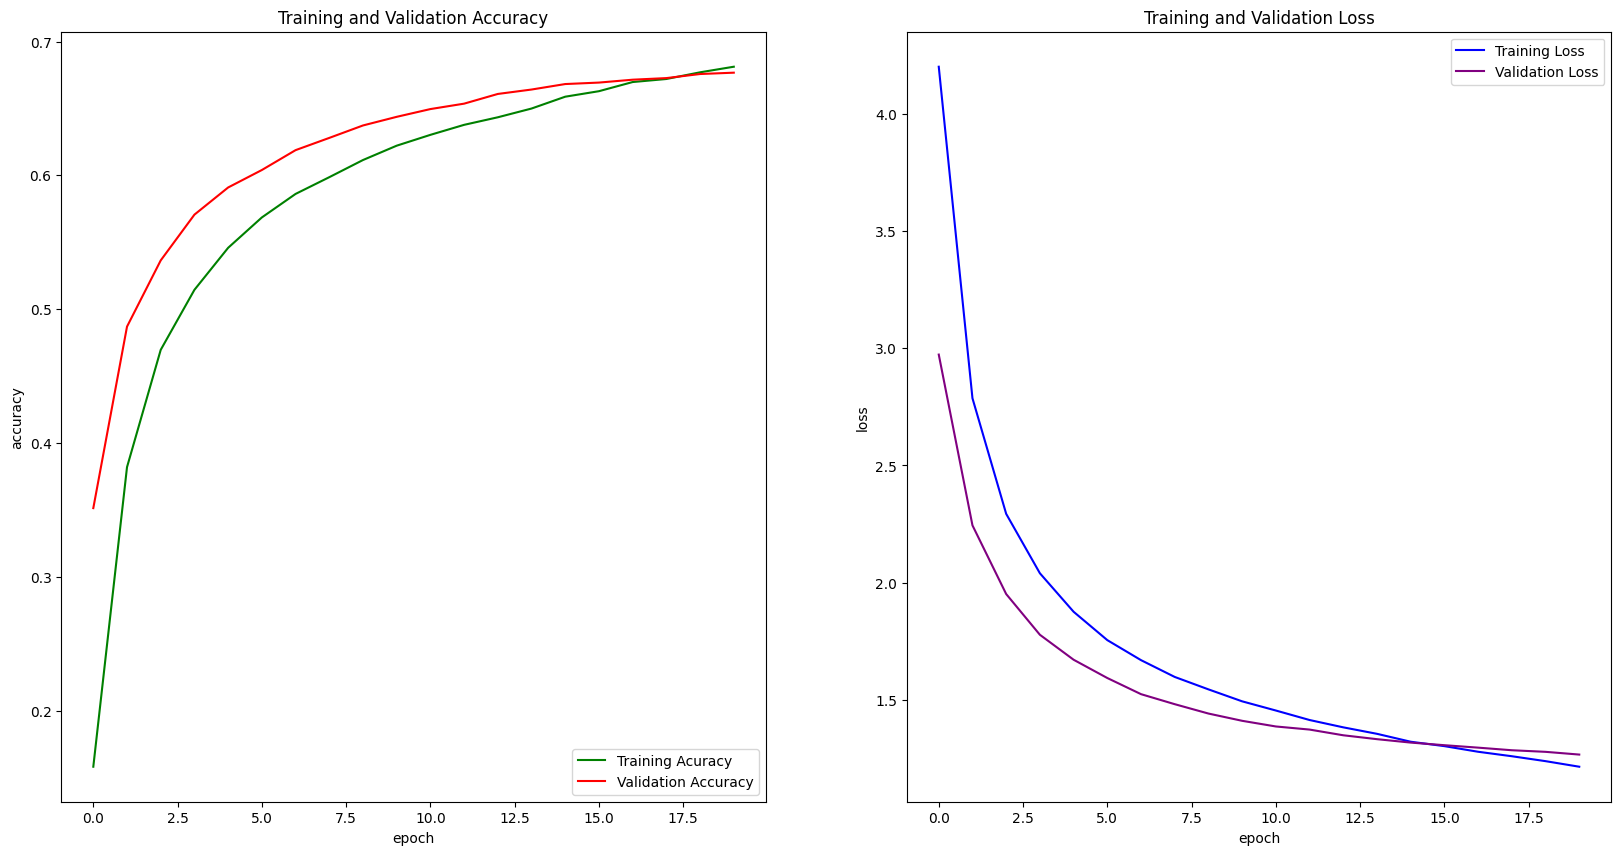

In [ ]:
plot_acc_loss(result)


## Predictions,Accuracy and Confusion Matrix
### ** Requires modification for proper format **

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = test_labels.ravel()
print(y_pred.shape,y_true.shape)


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step
(10000,) (2000000,)


In [ ]:
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [2000000, 10000]

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cm